# Predict Future Sales

Second part of feauture enginering and ML modeling - testing advanced models and advanced features

kaggle link : https://www.kaggle.com/c/competitive-data-science-predict-future-sales/overview

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns; sns.set()
from dateutil.relativedelta import relativedelta
import os

In [2]:
from my_functions import merge_basic, convert_silver, completion_semi_gold, scaler, inversed_scale, consolidation_prediction, plot_prediction
from my_functions import preparing_to_predict, plot_metrics, test_dates
from my_functions import my_kfold_crossval_and_Hptunning, My_ML_prediction_on_test, scaler, consolidated_metrics_MSE, consolidated_plot_metrics
from my_functions import augmentation_reduction, get_splited_data

In [3]:
from especial_functions import balance_items_test, get_full_lags, feature_silver, integration_new_features_map
from especial_functions import features_rows_train_silver, exploiting_words, get_maps_from, balance_items_test

In [4]:
from sklearn.preprocessing import MinMaxScaler

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor,AdaBoostRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error

## The Data

In [5]:
dictionary_data = get_splited_data(dates_vector = test_dates)

2014-11-01
2015-04-01
2015-05-01
2015-06-01
2015-07-01
2015-08-01
2015-09-01
2015-10-01


### Gradient Boosting

In [6]:
test_dates = [datetime.datetime(2014, 11, 1), datetime.datetime(2015, 4, 1), datetime.datetime(2015, 5, 1), datetime.datetime(2015, 6, 1), datetime.datetime(2015, 7, 1), datetime.datetime(2015, 8, 1),
datetime.datetime(2015, 9, 1), datetime.datetime(2015, 10, 1),]

In [7]:
my_gbr_models = list()
number_of_machines = 10
machines_labels = [f'machine-{x}' for x in range(1,number_of_machines +1) ]

parameters = { 'Machine':machines_labels,
    'max_depth': [40,30, 20, 35, 35, 30, 25, 25, 30, 40],
    'min_samples_split':[5, 4, 10, 7, 9, 15, 3, 3, 5, 5],
    'min_samples_leaf':[10, 7, 12, 5, 4, 3, 3, 3, 15, 12],
    'max_features':[25, 22, 25, 25, 28, 19, 23, 22, 25, 20],
    'n_estimators' : [50, 45, 90, 100, 50, 35, 150, 120, 85, 60],
    'learning_rate' : [0.05, 0.12, 0.02, 0.04, 0.004, 0.0003, 0.15, 0.08, 0.001, 0.005] }

for i in range(number_of_machines):
    max_depth_param = parameters['max_depth'][i]
    min_samples_split_param = parameters['min_samples_split'][i]
    min_samples_leaf_param = parameters['min_samples_leaf'][i]
    max_features_param = parameters['max_features'][i]
    
    n_estimators_param = parameters['n_estimators'][i]
    learning_rate_param = parameters['learning_rate'][i]
    
    my_adab = GradientBoostingRegressor( n_estimators = n_estimators_param, learning_rate = learning_rate_param, loss='squared_error',
                                       max_depth = max_depth_param, min_samples_split = min_samples_split_param , max_features = max_features_param,
                                       min_samples_leaf = min_samples_leaf_param)
    my_gbr_models.append(my_adab)

parameters_df = pd.DataFrame(parameters)  

In [8]:
%%time
my_test_results = my_kfold_crossval_and_Hptunning(data_dict = dictionary_data, models_toTrain =  [my_gbr_models[0]], frac = 0.25)

machine-1 is done
Wall time: 8min 4s


In [9]:
metrics_toplot = consolidated_plot_metrics(my_test_results)

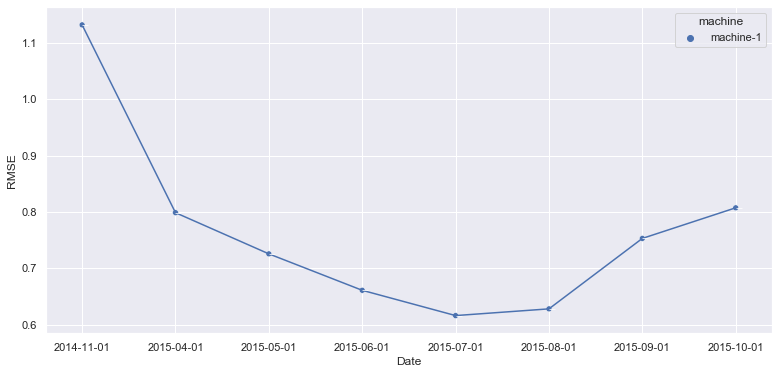

In [10]:
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(13,6), sharex=True)
ax = sns.lineplot(ax = axs , data = metrics_toplot, x="Date", y="RMSE", marker = True, hue = 'machine', legend = False )
ax = sns.scatterplot(ax = axs , data = metrics_toplot, x="Date", y="RMSE", s = 35, hue= 'machine' )

In [11]:
consolidated_metrics_MSE(my_test_results)

,machine,RMSE
0,machine-1,0.780742


### Kfold cross validation and hyper parameter tunning

In [12]:
my_test_results = my_kfold_crossval_and_Hptunning(data_dict = dictionary_data, models_toTrain =  my_gbr_models, frac = 0.15)

machine-1 is done
machine-2 is done
machine-3 is done
machine-4 is done
machine-5 is done
machine-6 is done
machine-7 is done
machine-8 is done
machine-9 is done
machine-10 is done


In [13]:
metrics_toplot = consolidated_plot_metrics(my_test_results)

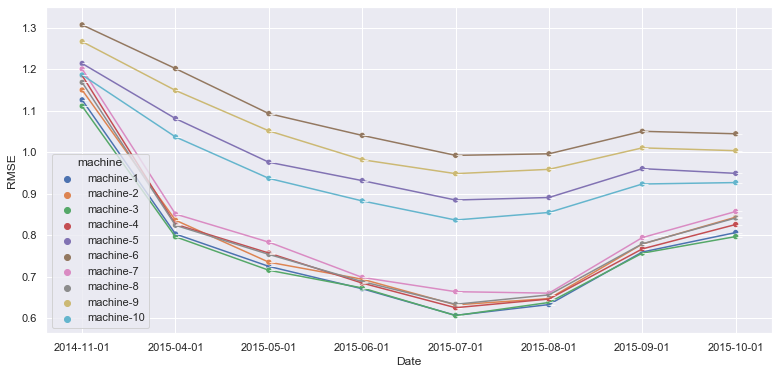

In [14]:
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(13,6), sharex=True)
ax = sns.lineplot(ax = axs , data = metrics_toplot, x="Date", y="RMSE", marker = True, hue = 'machine', legend = False )
ax = sns.scatterplot(ax = axs , data = metrics_toplot, x="Date", y="RMSE", s = 35, hue= 'machine' )

In [15]:
consolidated_metrics_MSE(my_test_results)

,machine,RMSE
2,machine-3,0.775906
0,machine-1,0.781448
1,machine-2,0.804765
3,machine-4,0.806918
7,machine-8,0.808884
6,machine-7,0.829976
9,machine-10,0.954181
4,machine-5,0.991493
8,machine-9,1.051424
5,machine-6,1.095683


the winner machine is 3(2)

### Winner Prediction

In [17]:
my_test_results = my_kfold_crossval_and_Hptunning(data_dict = dictionary_data, models_toTrain =  [my_gbr_models[2]], frac = 0.50)

machine-1 is done


In [18]:
metrics_toplot = consolidated_plot_metrics(my_test_results)

In [19]:
np.mean(metrics_toplot.RMSE)  ## 0.7634630008283754 best

0.7634630008283754

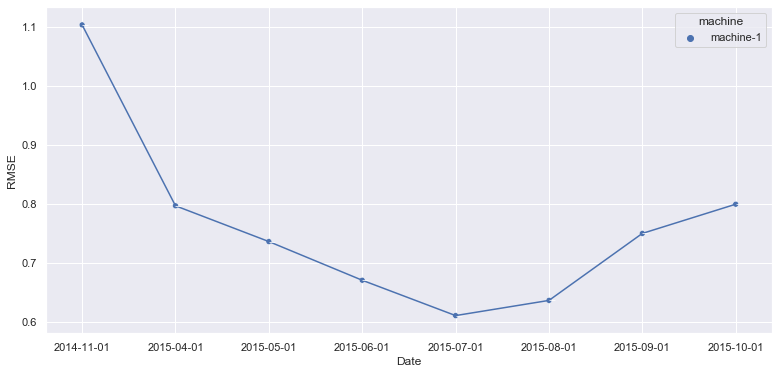

In [20]:
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(13,6), sharex=True)
ax = sns.lineplot(ax = axs , data = metrics_toplot, x="Date", y="RMSE", marker = True, hue = 'machine', legend = False )
ax = sns.scatterplot(ax = axs , data = metrics_toplot, x="Date", y="RMSE", s = 35, hue= 'machine' )

### Saving Results for Stacking

In [21]:
my_test_results['machine result'][0].to_csv('preds_stacking/preds_gradboost.csv',header = True, index = False)

----

### Random Forest

In [22]:
my_rf_models = list()
number_of_machines = 10
machines_labels = [f'machine-{x}' for x in range(1,number_of_machines +1) ]

parameters = { 'Machine':machines_labels,
    'max_depth': [40,30, 20, 35, 35, 30, 25, 25, 30, 40],
    'min_samples_split':[5, 4, 10, 7, 9, 15, 3, 3, 5, 5],
    'min_samples_leaf':[10, 7, 12, 5, 4, 3, 3, 3, 15, 12],
    'max_features':[25, 22, 25, 25, 10, 19, 23, 22, 25, 20],
    'n_estimators' : [300, 250, 150, 150, 250, 335, 250, 120, 285, 360]}

for i in range(number_of_machines):
    max_depth_param = parameters['max_depth'][i]
    min_samples_split_param = parameters['min_samples_split'][i]
    min_samples_leaf_param = parameters['min_samples_leaf'][i]
    max_features_param = parameters['max_features'][i]
    n_estimators_param = parameters['n_estimators'][i]
    
    my_rf = GradientBoostingRegressor( n_estimators = n_estimators_param, max_depth = max_depth_param, min_samples_split = min_samples_split_param ,
                                      max_features = max_features_param, min_samples_leaf = min_samples_leaf_param)
    my_rf_models.append(my_rf)

parameters_df = pd.DataFrame(parameters)  

In [23]:
%%time
my_test_results = my_kfold_crossval_and_Hptunning(data_dict = dictionary_data, models_toTrain =  [my_rf_models[0]], frac = 0.05)

machine-1 is done
Wall time: 16min 8s


In [24]:
metrics_toplot = consolidated_plot_metrics(my_test_results)

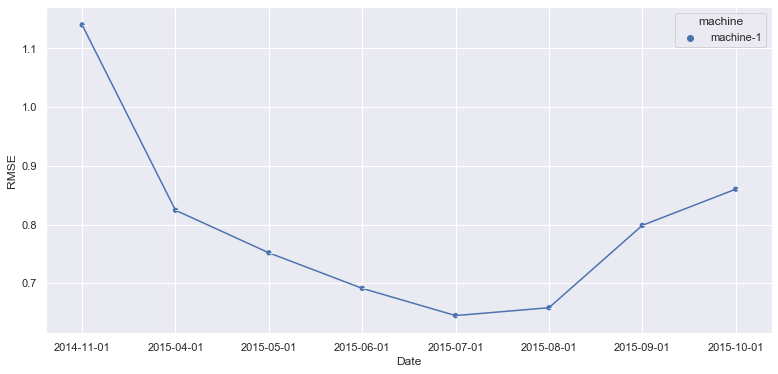

In [25]:
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(13,6), sharex=True)
ax = sns.lineplot(ax = axs , data = metrics_toplot, x="Date", y="RMSE", marker = True, hue = 'machine', legend = False )
ax = sns.scatterplot(ax = axs , data = metrics_toplot, x="Date", y="RMSE", s = 35, hue= 'machine' )

In [26]:
consolidated_metrics_MSE(my_test_results)

,machine,RMSE
0,machine-1,0.810099


### Kfold cross validation and hyper parameter tunning

In [27]:
my_test_results = my_kfold_crossval_and_Hptunning(data_dict = dictionary_data, models_toTrain =  my_rf_models, frac = 0.005)

machine-1 is done
machine-2 is done
machine-3 is done
machine-4 is done
machine-5 is done
machine-6 is done
machine-7 is done
machine-8 is done
machine-9 is done
machine-10 is done


In [28]:
metrics_toplot = consolidated_plot_metrics(my_test_results)

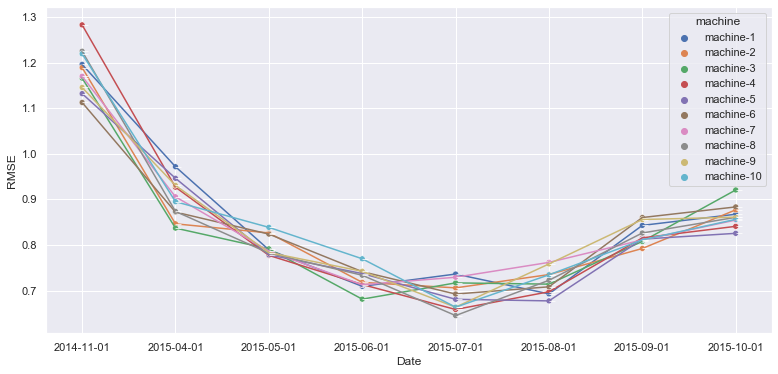

In [29]:
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(13,6), sharex=True)
ax = sns.lineplot(ax = axs , data = metrics_toplot, x="Date", y="RMSE", marker = True, hue = 'machine', legend = False )
ax = sns.scatterplot(ax = axs , data = metrics_toplot, x="Date", y="RMSE", s = 35, hue= 'machine' )

In [30]:
consolidated_metrics_MSE(my_test_results)

,machine,RMSE
4,machine-5,0.836028
2,machine-3,0.842268
5,machine-6,0.846253
1,machine-2,0.848914
7,machine-8,0.849712
6,machine-7,0.852737
8,machine-9,0.853876
3,machine-4,0.859516
9,machine-10,0.862783
0,machine-1,0.865039


Random Forest is not an option

---

### Stacking

In [31]:
preds_gradBoost = pd.read_csv('preds_stacking/preds_gradboost.csv').rename(columns = {'PredSale':'PredSale_gradBoost'})
preds_adaBoost = pd.read_csv('preds_stacking/preds_adaboost.csv').rename(columns = {'PredSale':'PredSale_adaBoost'})

In [32]:
columns_1 = ['Date','shop_id','item_id','PredSale_gradBoost','Sale']
columns_2 = ['PredSale_adaBoost']

In [33]:
merge_preds = preds_gradBoost[columns_1].merge(preds_adaBoost[columns_2], left_index=True, right_index=True, how = 'left')
merge_preds['Date'] = pd.to_datetime(merge_preds.Date)
merge_preds['month'] = merge_preds.Date.dt.month

##### Train stacking data

In [34]:
my_features_stack = ['PredSale_gradBoost','PredSale_adaBoost','item_id', 'shop_id']
my_target = 'Sale'

In [35]:
merge_preds.head()

,Date,shop_id,item_id,PredSale_gradBoost,Sale,PredSale_adaBoost,month
0,2014-11-01,0,30,0.122366,0.0,0.000000,11
1,2014-11-01,0,31,0.173995,0.0,0.000000,11
2,2014-11-01,0,32,0.996559,0.0,0.000000,11
3,2014-11-01,0,33,0.283803,0.0,0.000000,11
4,2014-11-01,0,35,0.156382,0.0,0.142857,11


In [36]:
merge_preds.PredSale_adaBoost.max(), merge_preds.Sale.max(), merge_preds.PredSale_gradBoost.max()

(20.0, 20.0, 16.47112613974604)

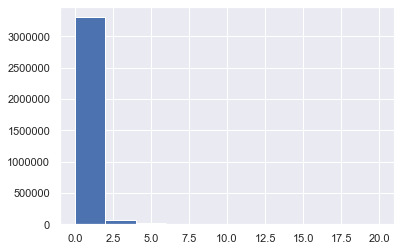

In [37]:
merge_preds.Sale.hist()

In [53]:
def augmentation_reduction_stack(data):
    data_wow = data.copy()
    data_wow = data_wow.reset_index(drop = True)
    zeros = np.array(data_wow[data_wow.Sale == 0].index)
    nx = int(round(zeros.shape[0]*0.80, 0))
    indexes = np.random.choice(zeros.shape[0], nx, replace=False)
    zeros_selected = zeros[indexes]
    data_wow = data_wow[ ~data_wow.index.isin(zeros_selected)]
    
    ones = np.array(data_wow[data_wow.Sale == 1].index)
    nx = int(round(ones.shape[0]*0.8, 0))
    indexes = np.random.choice(ones.shape[0], nx, replace=False)
    ones_selected = ones[indexes]
    data_wow = data_wow[ ~data_wow.index.isin(ones_selected)]
    
    twoes = np.array(data_wow[data_wow.Sale == 2].index)
    nx = int(round(twoes.shape[0]*0.2, 0))
    indexes = np.random.choice(twoes.shape[0], nx, replace=False)
    twoes_selected = twoes[indexes]
    data_wow = data_wow[ ~data_wow.index.isin(twoes_selected)]
    
    twenties = np.array(data_wow[data_wow.Sale == 20].index)
    nx = int(round(twenties.shape[0]*0.5, 0))
    indexes = np.random.choice(twenties.shape[0], nx, replace=False)
    twenties_selected = twenties[indexes]
    data_wow = data_wow[ ~data_wow.index.isin(twenties_selected)]
    
    #data_augmented_tens = data_wow[data_wow.Sale > 10].copy()
    data_augmented = pd.concat([data_wow, 
                               ],axis= 0).reset_index()
    
    return data_augmented

In [54]:
merge_preds_augmented = augmentation_reduction_stack(merge_preds)

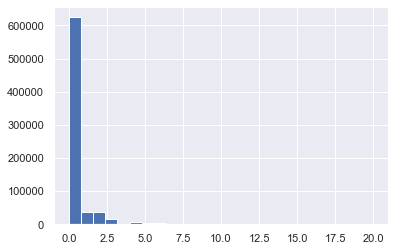

In [55]:
merge_preds_augmented.Sale.hist(bins = 25)

In [56]:
merge_preds_augmented.shape

(739333, 8)

In [57]:
data_to_use = merge_preds[my_features_stack + [my_target] ].copy()

val_index = list(data_to_use[data_to_use.Sale == 0].sample(frac = 0.05).index) + list(data_to_use[data_to_use.Sale != 0].sample(frac = 0.35).index)
val_data = data_to_use[data_to_use.index.isin(val_index)]

train_data = data_to_use[~data_to_use.index.isin(val_index)]
train_index = list(train_data[train_data.Sale == 0].sample(frac = 0.01).index) + list(train_data[train_data.Sale != 0].sample(frac = 0.85).index)
train_data = train_data[train_data.index.isin(train_index)]

In [58]:
X_train = train_data[my_features_stack]
Y_train = train_data[my_target]

X_val = val_data[my_features_stack].copy()

In [59]:
stacker = GradientBoostingRegressor( max_depth = 15,n_estimators = 40, learning_rate = 0.0015, loss='squared_error', )
stacker.fit(X_train, Y_train)

GradientBoostingRegressor(learning_rate=0.0015, max_depth=15, n_estimators=40)

In [60]:
Y_pred = stacker.predict(X_val)

In [61]:
val_data_v2 = val_data.copy()
val_data_v2['PredSale'] = Y_pred

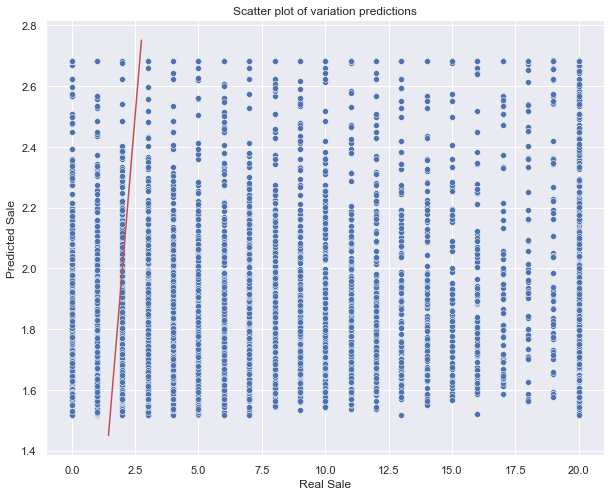

In [62]:
plot_prediction(val_data_v2)

In [63]:
mean_squared_error(val_data_v2['Sale'], val_data_v2['PredSale'])**(1/2) # 0.5152457526534849

1.9094099124638764

----

## Final Prediction

### Data

In [43]:
daily_train = pd.read_csv('sales_train.csv')
items = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')
categories = pd.read_csv('item_categories.csv')
sample_submission = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')

### Data modeling

In [65]:
date_val = datetime.datetime(2015, 11, 1)

In [66]:
train_merge = merge_basic(daily_train, test,'left')

In [67]:
train_merge.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,comp1_x,comp2_x,map_comp1categ,map_comp2categ,shop_name,comp1_y,comp2_y,map_comp1shop,map_comp2shop,ID,SaleDate
0,02.01.2013,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,Кино,Blu-Ray,11,19,"Ярославль ТЦ ""Альтаир""",Ярославль,Альтаир,31,45,150983.0,2013-01-02
1,03.01.2013,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,Музыка,Винил,13,39,"Москва ТРК ""Атриум""",Москва,Атриум,14,18,NaN,2013-01-03
2,05.01.2013,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,Музыка,Винил,13,39,"Москва ТРК ""Атриум""",Москва,Атриум,14,18,NaN,2013-01-05
3,06.01.2013,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,Музыка,Винил,13,39,"Москва ТРК ""Атриум""",Москва,Атриум,14,18,NaN,2013-01-06
4,15.01.2013,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,Музыка,CD фирменного производства,13,37,"Москва ТРК ""Атриум""",Москва,Атриум,14,18,NaN,2013-01-15


In [68]:
wholedata_silver = convert_silver(train_merge)

In [69]:
wholedata_silver.head()

,SaleDateMY,date_block_num,shop_id,item_id,item_name,item_category_id,shop_name,item_category_name,map_comp1categ,map_comp2categ,map_comp1shop,map_comp2shop,InTest,item_cnt_day,item_price,shopitem
0,2013-01-01,0,0,32,1+1,40,"!Якутск Орджоникидзе, 56 фран",Кино - DVD,11,22,0,0,0,6.0,221.0,0-32
1,2013-01-01,0,0,33,1+1 (BD),37,"!Якутск Орджоникидзе, 56 фран",Кино - Blu-Ray,11,19,0,0,0,3.0,347.0,0-33
2,2013-01-01,0,0,35,10 ЛЕТ СПУСТЯ,40,"!Якутск Орджоникидзе, 56 фран",Кино - DVD,11,22,0,0,0,1.0,247.0,0-35
3,2013-01-01,0,0,43,100 МИЛЛИОНОВ ЕВРО,40,"!Якутск Орджоникидзе, 56 фран",Кино - DVD,11,22,0,0,0,1.0,221.0,0-43
4,2013-01-01,0,0,51,100 лучших произведений классики (mp3-CD) (Dig...,57,"!Якутск Орджоникидзе, 56 фран",Музыка - MP3,13,38,0,0,0,2.0,130.0,0-51


In [70]:
### test preparation
test_data = test.copy()
test_data['date'] = pd.to_datetime(datetime.datetime(2015, 11, 1))
test_data['date_block_num'] = 34
test_data['item_price'] =  np.nan

test_data = test_data.merge(items, on = 'item_id',how = 'left')
test_data = test_data.merge(categories, on= 'item_category_id', how = 'left')
test_data['item_cnt_day'] = np.nan
test_data['shopitem'] = test_data['shop_id'].astype('str') + '-' + test_data['item_id'].astype('str')
test_data = test_data[['date','date_block_num','shop_id','item_id','item_price','item_cnt_day']]

In [71]:
test_data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2015-11-01,34,5,5037,NaN,NaN
1,2015-11-01,34,5,5320,NaN,NaN
2,2015-11-01,34,5,5233,NaN,NaN
3,2015-11-01,34,5,5232,NaN,NaN
4,2015-11-01,34,5,5268,NaN,NaN


In [72]:
test_data.shape 

(214200, 6)

In [73]:
date_val = datetime.datetime(2015, 11, 1)

In [75]:
train_full = completion_semi_gold(wholedata_silver)

In [5]:
maps = ['Starts','Focus_item_features','Focus_item_shop_features','item_name_explo','Focus_shop_features',
       'item previous var', 'lasthmonth_item', 'lasthOrder_item','meanL1Price_item',]

full_features_dictionary = get_maps_from(datex_str = '2015-11-01', maps = maps)

In [78]:
to_drop_columns = ['Date']
ids_columns = ['item_category_id',
       'ItemIdPart1','ItemIdPart2', 'CategIdItem3A', 'CategIdItem3B'] #'item_id'
numericals = [ 'Quarter', 'OrderGot', 'countItemPossitives',
       'countItemZero', 'L1maxLev1Item', 'L2maxLev1Item', 'L3maxLev1Item',
       'L4maxLev1Item', 'L5maxLev1Item',
       'countItemShopPossitives', 'countItemShopZero', 'L1maxLev1ItemShop',
       'L2maxLev1ItemShop', 'L3maxLev1ItemShop', 'L4maxLev1ItemShop',
       'L5maxLev1ItemShop', 'lenstr', 'NWords', 'Word0', 'Word_1',
       'L1maxLev1Shop', 'meanLaggedVars', 'item_idLastMonth1',
       'item_idLastMonth2', 'item_idLastMonth3', 'item_idLastMonth4',
       'item_idLastMonth5', 'item_idLastOrder1', 'item_idLastOrder2',
       'item_idLastOrder3', 'item_idLastOrder4', 'item_idLastOrder5',
       'meanL1Price', 'SpaceOrder'] + ids_columns

categoricals = ['SpaceOrderActivator', 'CategoryL1Item']
my_features = to_drop_columns + numericals + categoricals
my_target = 'Sale'
len(my_features) - 3

39

In [79]:
train_selection = pd.read_csv(f'generated_datasets/data_2015-11-01/train_selection.csv')

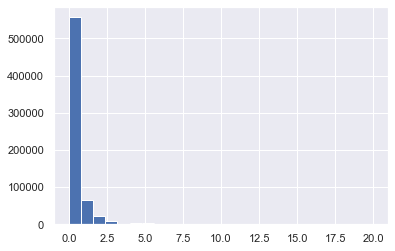

In [80]:
train_selection.Sale.hist(bins = 25)

In [81]:
train_augmented = augmentation_reduction(train_selection)

In [82]:
train_augmented.Sale.unique()

array([ 0.,  1.,  4.,  6.,  5., 10., 13.,  3., 11.,  8., 20.,  2., 14.,
       12., 18.,  9.,  7., 15., 16., 17., 19.])

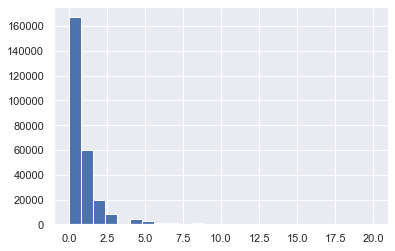

In [83]:
train_augmented.Sale.hist(bins = 25)

In [84]:
my_columns_to_drops = ['SpaceOrderActivator_B', 'CategoryL1Item_B', 'Quarter',
       'CategoryL1Item_C', 'CategoryL1Item_D', 'SpaceOrderActivator_A',
       'countItemShopPossitives', 'item_idLastMonth5',
       'item_idLastMonth4']

In [85]:
train_scaled, my_scaler = scaler(train_augmented, numericals, my_target, scaler=None, drop_columns = my_columns_to_drops)
#train_scaled = train_augmented[ numericals + [my_target] ]
if len(categoricals) != 0:
    train_dummies = pd.get_dummies(train_augmented[categoricals])
    train_scaled = pd.concat([train_dummies,train_scaled],axis = 1)

In [86]:
if len(categoricals) != 0:
    final_features = list(train_dummies.columns) +  numericals
else:
    final_features = numericals
final_features = [x for x in final_features if x not in my_columns_to_drops]

In [87]:
train_scaled.shape

(266085, 42)

### ML Training

In [88]:
train_scaled = train_scaled.sample(frac = 0.5)
X_train = train_scaled[final_features]
Y_train = train_scaled[my_target]

In [89]:
%%time
my_base = DecisionTreeRegressor(criterion = 'squared_error', max_depth = 45, min_samples_split = 15, min_samples_leaf = 5 , max_features = 21)
my_ABM = AdaBoostRegressor(base_estimator = my_base, n_estimators=35, learning_rate=0.0003, loss='linear')
my_ABM.fit(X_train, Y_train)

Wall time: 1min 5s


AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=45,
                                                       max_features=21,
                                                       min_samples_leaf=5,
                                                       min_samples_split=15),
                  learning_rate=0.0003, n_estimators=35)

In [90]:
%%time
my_adab = GradientBoostingRegressor( n_estimators = 90, learning_rate = 0.02, loss='squared_error', max_depth = 20, min_samples_split = 10 , 
                                    max_features = 25, min_samples_leaf = 12)
my_adab.fit(X_train, Y_train)

Wall time: 2min 48s


GradientBoostingRegressor(learning_rate=0.02, max_depth=20, max_features=25,
                          min_samples_leaf=12, min_samples_split=10,
                          n_estimators=90)

<b> prepare test to predict

In [91]:
test_data_merged = merge_basic(test_data, test,'inner')
val_window = convert_silver(test_data_merged)

In [92]:
full_valandtrain_selected = completion_semi_gold(val_window)

In [93]:
full_valandtrain_selected.shape

(214200, 17)

In [94]:
valandtrain_feature_firt = feature_silver(full_valandtrain_selected, date_to_take = date_val, Train = False)

In [95]:
valandtrain_feature_firt.shape

(214200, 28)

In [96]:
valandtrain_feature = integration_new_features_map(data = valandtrain_feature_firt, dict_feature = full_features_dictionary, filter_ceros = False) 

In [97]:
valandtrain_feature.shape

(214200, 63)

In [98]:
val_selection = features_rows_train_silver(data = valandtrain_feature, features = my_features, target = my_target, validation = date_val, additional_val_cols = ['shop_id', 'item_id'])

In [99]:
valandtrain_feature.shape, val_selection.shape, test.shape

((214200, 63), (214200, 45), (214200, 3))

In [100]:
val_scaled = scaler(val_selection, numericals, my_target, scaler=my_scaler,drop_columns = my_columns_to_drops )

if len(categoricals) != 0:
    val_dummies = pd.get_dummies(val_selection[categoricals])
    val_scaled_full = pd.concat([val_dummies,val_scaled],axis = 1)
else:
    val_scaled_full = val_scaled

In [101]:
X_val = val_scaled_full[final_features]

In [102]:
Y_pred_adaboost = my_ABM.predict(X_val)
Y_pred_gradboost = my_adab.predict(X_val)

In [103]:
predicted_val_adaboost = inversed_scale(scaler = my_scaler, data = val_scaled, target_name = my_target, y_pred = Y_pred_adaboost)
predicted_val_gradboost = inversed_scale(scaler = my_scaler, data = val_scaled, target_name = my_target, y_pred = Y_pred_gradboost)

In [104]:
my_lm_adaboost = consolidation_prediction(data = val_selection, prediction = predicted_val_adaboost.Sale.values).rename(columns = {'PredSale':'PredSale_adaBoost'})
my_lm_gradboost = consolidation_prediction(data = val_selection, prediction = predicted_val_gradboost.Sale.values).rename(columns = {'PredSale':'PredSale_gradBoost'})

In [105]:
merge_preds_val = my_lm_gradboost[columns_1].merge(my_lm_adaboost[columns_2], left_index=True, right_index=True, how = 'left')
merge_preds_val['Date'] = pd.to_datetime(merge_preds_val.Date)
merge_preds_val['month'] = merge_preds_val.Date.dt.month

In [106]:
my_features_stack = ['PredSale_gradBoost','PredSale_adaBoost','item_id', 'shop_id']
my_target = 'RealValueVar'

In [107]:
X_val = merge_preds_val[my_features_stack].copy()

In [108]:
Y_pred = stacker.predict(X_val)

In [109]:
val_data_v2 = merge_preds_val.copy()
val_data_v2 = val_data_v2.merge( test, on = ['shop_id', 'item_id'], how = 'left')
val_data_v2['PredictedVar'] = Y_pred
val_data_v2['PredSale'] = val_data_v2['PredictedVar'] + val_data_v2['Sale']
val_data_v2 = val_data_v2.sort_values('ID')

In [110]:
val_data_v2.to_csv('final_prediction.csv',header = True, index = False)

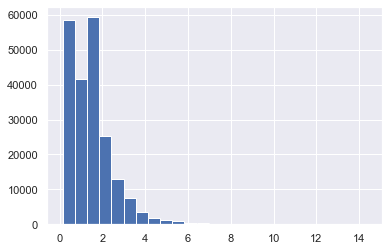

In [112]:
val_data_v2.PredSale_gradBoost.hist(bins = 25)

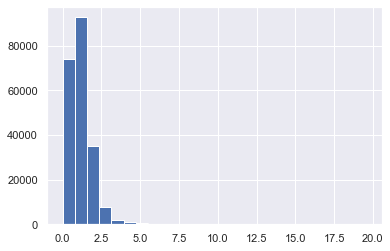

In [113]:
val_data_v2.PredSale_adaBoost.hist(bins = 25)

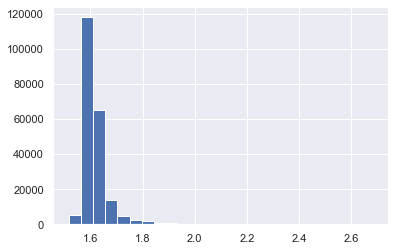

In [114]:
val_data_v2.PredSale.hist(bins = 25)

#### Continue.....

In [6]:
val_data_v2 = pd.read_csv('final_prediction.csv')

In [7]:
val_data_v2.head()

,Date,shop_id,item_id,PredSale_gradBoost,Sale,PredSale_adaBoost,month,ID,PredictedVar,PredSale
0,2015-11-01,5,5037,2.401116,0.0,1.555556,11,0,1.618828,1.618828
1,2015-11-01,5,5320,0.395454,0.0,0.000000,11,1,1.566991,1.566991
2,2015-11-01,5,5233,2.417309,0.0,1.583333,11,2,1.618828,1.618828
3,2015-11-01,5,5232,1.846133,0.0,1.800000,11,3,1.641581,1.641581
4,2015-11-01,5,5268,0.942790,0.0,0.000000,11,4,1.550038,1.550038


In [8]:
val_data_v2.shape

(214200, 10)

In [23]:
final_prediction = val_data_v2[['ID','shop_id','item_id','PredSale_adaBoost']]
final_prediction = final_prediction.rename(columns = {'PredSale_adaBoost': 'item_cnt_month'})
final_prediction['item_cnt_month'] = final_prediction['item_cnt_month'].clip(0,20)

In [11]:
final_prediction.to_csv('miguel_prediction.csv',index = False, header = True)

This result got 1.21 and 1.23

##### probing

In [24]:
dfx = full_features_dictionary['Focus_item_shop_features'].groupby(['item_id', 'shop_id']).agg(Found = ('countItemShopZero','max')).reset_index()
dfx['Found'] = True

In [33]:
df_go = final_prediction.merge(dfx, on = ['item_id','shop_id'], how = 'left')
df_go['Found'] = df_go['Found'].fillna(False)

In [34]:
df_go.groupby('Found').agg(count = ('ID','count'))

,count
Found,
False,102796
True,111404


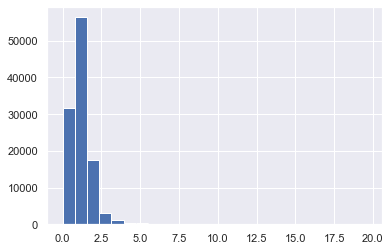

In [35]:
df_go[df_go.Found == True].item_cnt_month.hist(bins = 25)

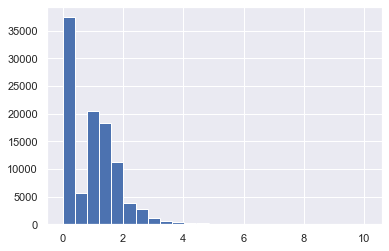

In [36]:
df_go[df_go.Found == False].item_cnt_month.hist(bins = 25)

In [38]:
df_go.head()

,ID,shop_id,item_id,item_cnt_month,Found
0,0,5,5037,1.555556,True
1,1,5,5320,0.000000,False
2,2,5,5233,1.583333,True
3,3,5,5232,1.800000,True
4,4,5,5268,0.000000,False


In [39]:
df_go['item_cnt_month'] = np.where(df_go.Found == False, 0, df_go['item_cnt_month'])

In [40]:
df_go.head()

,ID,shop_id,item_id,item_cnt_month,Found
0,0,5,5037,1.555556,True
1,1,5,5320,0.000000,False
2,2,5,5233,1.583333,True
3,3,5,5232,1.800000,True
4,4,5,5268,0.000000,False


In [41]:
df_go[['ID','item_cnt_month']].to_csv('miguel_prediction.csv',index = False, header = True)

this probing gor 1.21, then

In [94]:
test['Prediction'] = val_data_v2.PredSale.values
test['item_cnt_month'] = np.where(test['Prediction'] < 0 ,0 ,
                        np.where(test['Prediction'] > 20, 20, test['Prediction']))

test['item_cnt_month'] = np.where(test['item_cnt_month'] < 1 ,0.5 ,test['item_cnt_month'])

In [95]:
test.item_cnt_month.max(), test.item_cnt_month.min()

(0.5, 0.5)

In [13]:
test[['ID','item_cnt_month']].to_csv('miguel_prediction.csv',index = False, header = True)

the probing result is 1.22 and 1.23